# Exploring the SVHN Data

### Importing neccessary libraries

In [1]:

import numpy as np
import scipy.io as sio

import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


### Loading the test and training data

In [2]:
cropTensorTransform = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(31),
    torchvision.transforms.ToTensor()
])

In [3]:
train = torchvision.datasets.SVHN(root="data/", split="train", transform=torchvision.transforms.ToTensor())
test = torchvision.datasets.SVHN(root="data/", split="test", transform=torchvision.transforms.ToTensor())

### Preparing out data set

In [4]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = DataLoader(train, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size_test, shuffle=True)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape

torch.Size([1000, 3, 32, 32])

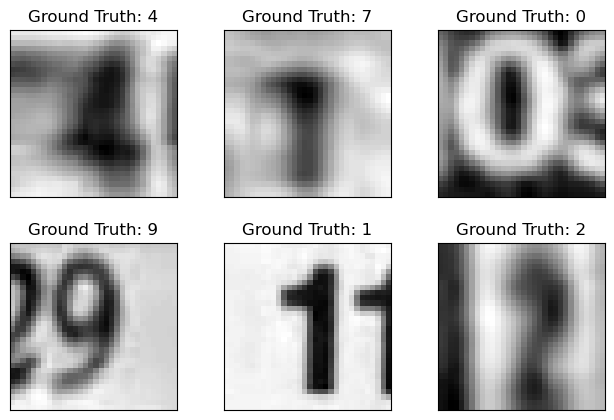

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig
plt.show()

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [9]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [10]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [11]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      #torch.save(network.state_dict(), '/results/model.pth')
      #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [12]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [14]:
print(example_data.shape)
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

torch.Size([1000, 3, 32, 32])


C:\Users\magma\AppData\Local\Temp\ipykernel_15328\235829359.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.2279, Accuracy: 5099/26032 (20%)

Train Epoch: 1 [0/73257 (0%)]	Loss: 2.206826
Train Epoch: 1 [640/73257 (1%)]	Loss: 2.153830
Train Epoch: 1 [1280/73257 (2%)]	Loss: 2.274289
Train Epoch: 1 [1920/73257 (3%)]	Loss: 2.243143
Train Epoch: 1 [2560/73257 (3%)]	Loss: 2.275769
Train Epoch: 1 [3200/73257 (4%)]	Loss: 2.287147
Train Epoch: 1 [3840/73257 (5%)]	Loss: 2.277512
Train Epoch: 1 [4480/73257 (6%)]	Loss: 2.216369
Train Epoch: 1 [5120/73257 (7%)]	Loss: 2.250292
Train Epoch: 1 [5760/73257 (8%)]	Loss: 2.249222
Train Epoch: 1 [6400/73257 (9%)]	Loss: 2.233748
Train Epoch: 1 [7040/73257 (10%)]	Loss: 2.251709
Train Epoch: 1 [7680/73257 (10%)]	Loss: 2.212352
Train Epoch: 1 [8320/73257 (11%)]	Loss: 2.250311
Train Epoch: 1 [8960/73257 (12%)]	Loss: 2.264438
Train Epoch: 1 [9600/73257 (13%)]	Loss: 2.205602
Train Epoch: 1 [10240/73257 (14%)]	Loss: 2.152807
Train Epoch: 1 [10880/73257 (15%)]	Loss: 2.230574
Train Epoch: 1 [11520/73257 (16%)]	Loss: 2.314644
Train Epoch: 1 [12160/7

Train Epoch: 2 [30720/73257 (42%)]	Loss: 2.321929
Train Epoch: 2 [31360/73257 (43%)]	Loss: 2.225720
Train Epoch: 2 [32000/73257 (44%)]	Loss: 2.234303
Train Epoch: 2 [32640/73257 (45%)]	Loss: 2.217024
Train Epoch: 2 [33280/73257 (45%)]	Loss: 2.253145
Train Epoch: 2 [33920/73257 (46%)]	Loss: 2.189816
Train Epoch: 2 [34560/73257 (47%)]	Loss: 2.246711
Train Epoch: 2 [35200/73257 (48%)]	Loss: 2.134391
Train Epoch: 2 [35840/73257 (49%)]	Loss: 2.197710
Train Epoch: 2 [36480/73257 (50%)]	Loss: 2.229653
Train Epoch: 2 [37120/73257 (51%)]	Loss: 2.142142
Train Epoch: 2 [37760/73257 (52%)]	Loss: 2.195328
Train Epoch: 2 [38400/73257 (52%)]	Loss: 2.279581
Train Epoch: 2 [39040/73257 (53%)]	Loss: 2.253262
Train Epoch: 2 [39680/73257 (54%)]	Loss: 2.277842
Train Epoch: 2 [40320/73257 (55%)]	Loss: 2.190041
Train Epoch: 2 [40960/73257 (56%)]	Loss: 2.201487
Train Epoch: 2 [41600/73257 (57%)]	Loss: 2.273732
Train Epoch: 2 [42240/73257 (58%)]	Loss: 2.213164
Train Epoch: 2 [42880/73257 (59%)]	Loss: 2.217199


Train Epoch: 3 [62720/73257 (86%)]	Loss: 1.525447
Train Epoch: 3 [63360/73257 (86%)]	Loss: 1.727306
Train Epoch: 3 [64000/73257 (87%)]	Loss: 1.629880
Train Epoch: 3 [64640/73257 (88%)]	Loss: 1.702627
Train Epoch: 3 [65280/73257 (89%)]	Loss: 1.603155
Train Epoch: 3 [65920/73257 (90%)]	Loss: 1.455372
Train Epoch: 3 [66560/73257 (91%)]	Loss: 1.626875
Train Epoch: 3 [67200/73257 (92%)]	Loss: 1.770323
Train Epoch: 3 [67840/73257 (93%)]	Loss: 1.554865
Train Epoch: 3 [68480/73257 (93%)]	Loss: 1.555542
Train Epoch: 3 [69120/73257 (94%)]	Loss: 1.577657
Train Epoch: 3 [69760/73257 (95%)]	Loss: 1.688619
Train Epoch: 3 [70400/73257 (96%)]	Loss: 1.446909
Train Epoch: 3 [71040/73257 (97%)]	Loss: 1.673127
Train Epoch: 3 [71680/73257 (98%)]	Loss: 1.578386
Train Epoch: 3 [72320/73257 (99%)]	Loss: 1.506306
Train Epoch: 3 [72960/73257 (100%)]	Loss: 1.570747

Test set: Avg. loss: 1.3400, Accuracy: 15765/26032 (61%)

Train Epoch: 4 [0/73257 (0%)]	Loss: 1.674364
Train Epoch: 4 [640/73257 (1%)]	Loss: 1.68020

Train Epoch: 5 [20480/73257 (28%)]	Loss: 1.382761
Train Epoch: 5 [21120/73257 (29%)]	Loss: 1.567350
Train Epoch: 5 [21760/73257 (30%)]	Loss: 1.304222
Train Epoch: 5 [22400/73257 (31%)]	Loss: 1.396766
Train Epoch: 5 [23040/73257 (31%)]	Loss: 1.159630
Train Epoch: 5 [23680/73257 (32%)]	Loss: 1.233393
Train Epoch: 5 [24320/73257 (33%)]	Loss: 1.164534
Train Epoch: 5 [24960/73257 (34%)]	Loss: 1.067725
Train Epoch: 5 [25600/73257 (35%)]	Loss: 1.200491
Train Epoch: 5 [26240/73257 (36%)]	Loss: 1.020516
Train Epoch: 5 [26880/73257 (37%)]	Loss: 1.305577
Train Epoch: 5 [27520/73257 (38%)]	Loss: 1.113110
Train Epoch: 5 [28160/73257 (38%)]	Loss: 1.291407
Train Epoch: 5 [28800/73257 (39%)]	Loss: 1.258544
Train Epoch: 5 [29440/73257 (40%)]	Loss: 1.598552
Train Epoch: 5 [30080/73257 (41%)]	Loss: 1.249158
Train Epoch: 5 [30720/73257 (42%)]	Loss: 1.548168
Train Epoch: 5 [31360/73257 (43%)]	Loss: 1.306211
Train Epoch: 5 [32000/73257 (44%)]	Loss: 1.190072
Train Epoch: 5 [32640/73257 (45%)]	Loss: 1.399449


Train Epoch: 6 [51840/73257 (71%)]	Loss: 1.146849
Train Epoch: 6 [52480/73257 (72%)]	Loss: 1.093646
Train Epoch: 6 [53120/73257 (72%)]	Loss: 0.976828
Train Epoch: 6 [53760/73257 (73%)]	Loss: 0.942074
Train Epoch: 6 [54400/73257 (74%)]	Loss: 0.983003
Train Epoch: 6 [55040/73257 (75%)]	Loss: 0.998400
Train Epoch: 6 [55680/73257 (76%)]	Loss: 0.902093
Train Epoch: 6 [56320/73257 (77%)]	Loss: 1.204336
Train Epoch: 6 [56960/73257 (78%)]	Loss: 0.826352
Train Epoch: 6 [57600/73257 (79%)]	Loss: 0.965686
Train Epoch: 6 [58240/73257 (79%)]	Loss: 1.105714
Train Epoch: 6 [58880/73257 (80%)]	Loss: 1.212415
Train Epoch: 6 [59520/73257 (81%)]	Loss: 1.149719
Train Epoch: 6 [60160/73257 (82%)]	Loss: 1.092456
Train Epoch: 6 [60800/73257 (83%)]	Loss: 1.200143
Train Epoch: 6 [61440/73257 (84%)]	Loss: 1.145506
Train Epoch: 6 [62080/73257 (85%)]	Loss: 1.121098
Train Epoch: 6 [62720/73257 (86%)]	Loss: 1.241902
Train Epoch: 6 [63360/73257 (86%)]	Loss: 1.163587
Train Epoch: 6 [64000/73257 (87%)]	Loss: 1.209210


Train Epoch: 8 [9600/73257 (13%)]	Loss: 0.938565
Train Epoch: 8 [10240/73257 (14%)]	Loss: 1.011375
Train Epoch: 8 [10880/73257 (15%)]	Loss: 1.005223
Train Epoch: 8 [11520/73257 (16%)]	Loss: 1.430014
Train Epoch: 8 [12160/73257 (17%)]	Loss: 0.984467
Train Epoch: 8 [12800/73257 (17%)]	Loss: 1.356707
Train Epoch: 8 [13440/73257 (18%)]	Loss: 1.008999
Train Epoch: 8 [14080/73257 (19%)]	Loss: 0.943166
Train Epoch: 8 [14720/73257 (20%)]	Loss: 0.783862
Train Epoch: 8 [15360/73257 (21%)]	Loss: 1.202492
Train Epoch: 8 [16000/73257 (22%)]	Loss: 1.021595
Train Epoch: 8 [16640/73257 (23%)]	Loss: 0.799278
Train Epoch: 8 [17280/73257 (24%)]	Loss: 0.963839
Train Epoch: 8 [17920/73257 (24%)]	Loss: 1.078692
Train Epoch: 8 [18560/73257 (25%)]	Loss: 0.909528
Train Epoch: 8 [19200/73257 (26%)]	Loss: 0.865839
Train Epoch: 8 [19840/73257 (27%)]	Loss: 0.800002
Train Epoch: 8 [20480/73257 (28%)]	Loss: 0.896129
Train Epoch: 8 [21120/73257 (29%)]	Loss: 1.157618
Train Epoch: 8 [21760/73257 (30%)]	Loss: 0.996259
T

Train Epoch: 9 [40960/73257 (56%)]	Loss: 0.953051
Train Epoch: 9 [41600/73257 (57%)]	Loss: 0.950181
Train Epoch: 9 [42240/73257 (58%)]	Loss: 0.960683
Train Epoch: 9 [42880/73257 (59%)]	Loss: 0.906392
Train Epoch: 9 [43520/73257 (59%)]	Loss: 0.948021
Train Epoch: 9 [44160/73257 (60%)]	Loss: 0.981354
Train Epoch: 9 [44800/73257 (61%)]	Loss: 1.079652
Train Epoch: 9 [45440/73257 (62%)]	Loss: 1.192654
Train Epoch: 9 [46080/73257 (63%)]	Loss: 0.953758
Train Epoch: 9 [46720/73257 (64%)]	Loss: 0.763660
Train Epoch: 9 [47360/73257 (65%)]	Loss: 1.030377
Train Epoch: 9 [48000/73257 (66%)]	Loss: 0.828095
Train Epoch: 9 [48640/73257 (66%)]	Loss: 0.806058
Train Epoch: 9 [49280/73257 (67%)]	Loss: 0.925825
Train Epoch: 9 [49920/73257 (68%)]	Loss: 0.833358
Train Epoch: 9 [50560/73257 (69%)]	Loss: 1.019718
Train Epoch: 9 [51200/73257 (70%)]	Loss: 1.086897
Train Epoch: 9 [51840/73257 (71%)]	Loss: 1.046625
Train Epoch: 9 [52480/73257 (72%)]	Loss: 0.910406
Train Epoch: 9 [53120/73257 (72%)]	Loss: 0.922829


Train Epoch: 10 [71040/73257 (97%)]	Loss: 0.823485
Train Epoch: 10 [71680/73257 (98%)]	Loss: 0.829428
Train Epoch: 10 [72320/73257 (99%)]	Loss: 0.689692
Train Epoch: 10 [72960/73257 (100%)]	Loss: 0.833525

Test set: Avg. loss: 0.6516, Accuracy: 21445/26032 (82%)



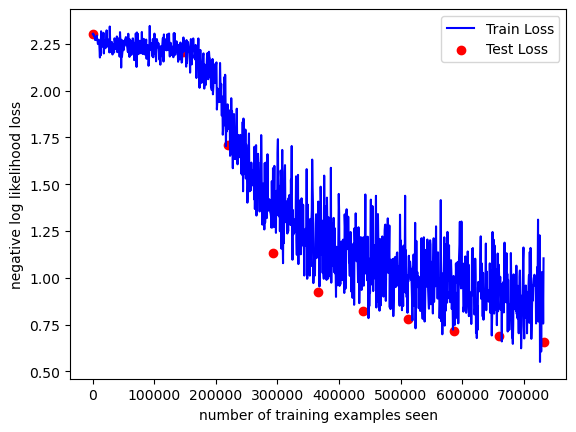

In [18]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig
plt.show()

In [18]:
with torch.no_grad():
  output = network(example_data)

C:\Users\magma\AppData\Local\Temp\ipykernel_15328\235829359.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


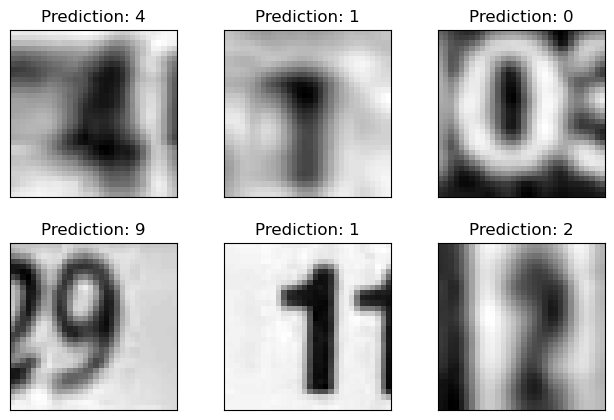

In [19]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig
plt.show()

In [7]:
# Generate graph for center crop 32 -> 1

last_test_losses = []

for i in range(32,0,-1):
    cropTensorTransform = torchvision.transforms.Compose([
        torchvision.transforms.CenterCrop(i),
        torchvision.transforms.ToTensor()
    ])

    train = torchvision.datasets.SVHN(root="data/", split="train", transform=cropTensorTransform)
    test = torchvision.datasets.SVHN(root="data/", split="test", transform=torchvision.transforms.ToTensor())

    network = Net()
    optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                          momentum=momentum)
    
    def train(epoch):
      network.train()
      for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
          train_losses.append(loss.item())
          train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    
    def test():
      network.eval()
      test_loss = 0
      correct = 0
      with torch.no_grad():
        for data, target in test_loader:
          output = network(data)
          test_loss += F.nll_loss(output, target, size_average=False).item()
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).sum()
      test_loss /= len(test_loader.dataset)
      test_losses.append(test_loss)
      print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
    
    test()
    for epoch in range(1, n_epochs + 1):
      train(epoch)
      test()
    
    last_test_losses.append(test_losses[-1])
    print("One center crop iteration done")
        
    


C:\Users\magma\AppData\Local\Temp\ipykernel_1720\235829359.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
C:\Users\magma\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3034, Accuracy: 1977/26032 (8%)


Test set: Avg. loss: 2.2237, Accuracy: 5099/26032 (20%)


Test set: Avg. loss: 2.2057, Accuracy: 5099/26032 (20%)


Test set: Avg. loss: 1.7145, Accuracy: 12009/26032 (46%)


Test set: Avg. loss: 1.1374, Accuracy: 17853/26032 (69%)


Test set: Avg. loss: 0.9435, Accuracy: 19547/26032 (75%)


Test set: Avg. loss: 0.8384, Accuracy: 20248/26032 (78%)


Test set: Avg. loss: 0.7698, Accuracy: 20685/26032 (79%)


Test set: Avg. loss: 0.7507, Accuracy: 20871/26032 (80%)


Test set: Avg. loss: 0.6811, Accuracy: 21247/26032 (82%)


Test set: Avg. loss: 0.6699, Accuracy: 21297/26032 (82%)

One center crop iteration done

Test set: Avg. loss: 2.3023, Accuracy: 3305/26032 (13%)


Test set: Avg. loss: 2.2263, Accuracy: 5099/26032 (20%)


Test set: Avg. loss: 2.2202, Accuracy: 5099/26032 (20%)


Test set: Avg. loss: 2.1427, Accuracy: 5292/26032 (20%)


Test set: Avg. loss: 1.6762, Accuracy: 13104/26032 (50%)


Test set: Avg. loss: 1.1947, Acc


Test set: Avg. loss: 2.1967, Accuracy: 5099/26032 (20%)


Test set: Avg. loss: 1.8530, Accuracy: 9657/26032 (37%)


Test set: Avg. loss: 1.2205, Accuracy: 17319/26032 (67%)


Test set: Avg. loss: 0.9885, Accuracy: 19268/26032 (74%)


Test set: Avg. loss: 0.8465, Accuracy: 20352/26032 (78%)


Test set: Avg. loss: 0.7385, Accuracy: 20977/26032 (81%)


Test set: Avg. loss: 0.6969, Accuracy: 21175/26032 (81%)


Test set: Avg. loss: 0.6851, Accuracy: 21142/26032 (81%)


Test set: Avg. loss: 0.6553, Accuracy: 21366/26032 (82%)

One center crop iteration done

Test set: Avg. loss: 2.3079, Accuracy: 2521/26032 (10%)


Test set: Avg. loss: 2.2258, Accuracy: 5099/26032 (20%)


Test set: Avg. loss: 2.2142, Accuracy: 5099/26032 (20%)


Test set: Avg. loss: 1.8392, Accuracy: 11036/26032 (42%)


Test set: Avg. loss: 1.0882, Accuracy: 18687/26032 (72%)


Test set: Avg. loss: 0.8764, Accuracy: 20146/26032 (77%)


Test set: Avg. loss: 0.7842, Accuracy: 20683/26032 (79%)


Test set: Avg. loss: 0.7437, 


Test set: Avg. loss: 1.1039, Accuracy: 18102/26032 (70%)


Test set: Avg. loss: 0.8586, Accuracy: 20121/26032 (77%)


Test set: Avg. loss: 0.7557, Accuracy: 20751/26032 (80%)


Test set: Avg. loss: 0.6946, Accuracy: 21161/26032 (81%)


Test set: Avg. loss: 0.6706, Accuracy: 21375/26032 (82%)


Test set: Avg. loss: 0.6255, Accuracy: 21504/26032 (83%)


Test set: Avg. loss: 0.6034, Accuracy: 21618/26032 (83%)

One center crop iteration done

Test set: Avg. loss: 2.2933, Accuracy: 2438/26032 (9%)


Test set: Avg. loss: 2.2249, Accuracy: 5099/26032 (20%)


Test set: Avg. loss: 2.2210, Accuracy: 5099/26032 (20%)


Test set: Avg. loss: 2.0797, Accuracy: 8060/26032 (31%)


Test set: Avg. loss: 1.4045, Accuracy: 14721/26032 (57%)


Test set: Avg. loss: 1.0109, Accuracy: 18529/26032 (71%)


Test set: Avg. loss: 0.8224, Accuracy: 20267/26032 (78%)


Test set: Avg. loss: 0.7179, Accuracy: 20906/26032 (80%)


Test set: Avg. loss: 0.6613, Accuracy: 21204/26032 (81%)


Test set: Avg. loss: 0.6432, 

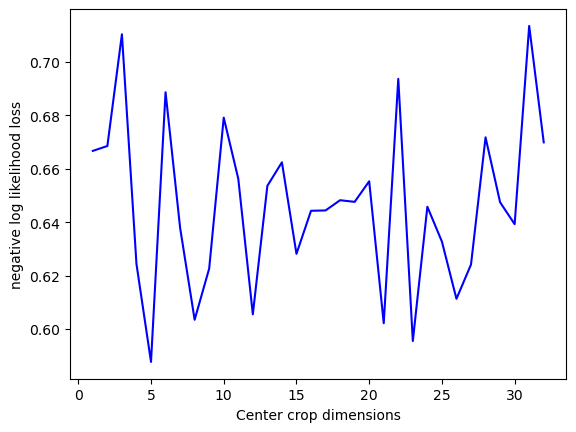

In [8]:
fig = plt.figure()
plt.plot(list(range(32,0,-1)), last_test_losses, color='blue')
plt.xlabel('Center crop dimensions')
plt.ylabel('negative log likelihood loss')
plt.show()

In [9]:
print(last_test_losses)

[0.6699187621501742, 0.7135488935680424, 0.6392446897040135, 0.647458518291443, 0.6717851083558545, 0.6241221161949613, 0.6112761633778615, 0.6327219943950421, 0.6457859585456637, 0.5954581815623475, 0.6936995689313545, 0.6021310450038664, 0.6553222773334477, 0.6476129223835857, 0.648227546943355, 0.6443995586845431, 0.6442622083348589, 0.6281300644311864, 0.6624374605793123, 0.6536179759711961, 0.6054676136284719, 0.6562863168499553, 0.6791694350380362, 0.622633314308537, 0.6034220038708837, 0.6379321329272739, 0.6886858751089499, 0.5876244966355144, 0.6243510457292685, 0.7104150022402378, 0.6685454825645732, 0.6667182392772166]
